In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.impute import KNNImputer
import pickle
import sys
sys.path.append('../utils')
from modeling import split_data, train_model
import matplotlib.pyplot as plt

# Import raw data (test)

In [5]:
shhs1 = pd.read_csv('../../data/raw/shhs1-dataset-0.20.0.csv', encoding='cp1252', engine='python')

# Antropometric features and Lifestyle and Behavioural features 

In [6]:
df = shhs1[['hip', 'neck20', 'coffee15', 'tea15', 'soda15', 'evsmok15','smknow15', 'asa15', 
            'smokstat_s1', 'bmi_s1', 'weight', 'waist','height', 'weight20', 'nsrrid', 
       'ahi_c0h4']]

# Preprocess data for model use

In [7]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
imputer = KNNImputer(n_neighbors=5)  # You can change the number of neighbors if needed
df_imputed_scaled = imputer.fit_transform(df_scaled)
df_imputed = scaler.inverse_transform(df_imputed_scaled)
df = pd.DataFrame(df_imputed, columns=df.columns)

# Train model (would remove if we have pkl for best model in 'models/cheap_features/')

In [8]:
# load data and model
best_model = pickle.load(open('../../models/cheap_features/ridge.pkl', 'rb'))
best_model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': 1,
 'solver': 'auto',
 'tol': 0.0001}

In [9]:
target = 'ahi_c0h4'
features = df.columns.tolist()
features.remove(target)
X_train, X_test, y_train, y_test, X_val, y_val = split_data(df, features, target)

In [10]:
# do RandomizedSearchCV to find best hyperparameters
model = Ridge(random_state=1)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

# Split data
X_train, X_test, y_train, y_test, X_val, y_val = split_data(df, features, target)

param_grid = {
    'alpha': uniform(0, 10),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

search = RandomizedSearchCV(model, param_grid, n_iter=20, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=1)
search.fit(X_train, y_train)
print(search.best_params_)
print(search.best_score_)
print(search.best_estimator_)
best_param = search.best_params_
best_model = search.best_estimator_

/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/py

{'alpha': 4.17022004702574, 'solver': 'sparse_cg'}
-4.72320786153514
Ridge(alpha=4.17022004702574, random_state=1, solver='sparse_cg')


/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Predict CAHI

In [11]:
# all input
all_input = df[['hip', 'neck20', 'coffee15', 'tea15', 'soda15', 'evsmok15','smknow15', 'asa15', 
            'smokstat_s1', 'bmi_s1', 'weight', 'waist','height', 'weight20', 'nsrrid']]
CAHI_prediction = best_model.predict(all_input)
CAHI_prediction

array([ 4.67371113, 17.31812425,  5.97412821, ...,  2.89369926,
        6.49793198, 13.31506818])

In [12]:
# sample input
sample_input = [99.0,38.3,2.0,0.0,1.0,1.0,0.0,1.0,2.0,21.777553339,65.0,86.0,178.0,69.0,200001]
CAHI_prediction_sample = best_model.predict(np.array(sample_input).reshape(1,-1))

/Users/huailintang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


# Diagnose CSA

In [17]:
diagnosis_new = CAHI_prediction > 2

In [18]:
CAHI_prediction_sample > 2

array([ True])

# Present results

Comparing CAHI actual value with predicted value

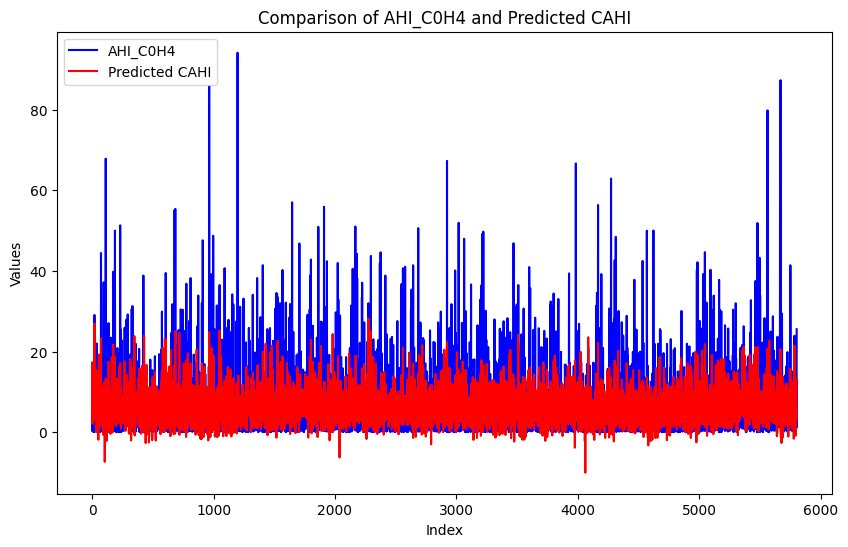

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df['ahi_c0h4'], label='AHI_C0H4', color='blue')
plt.plot(CAHI_prediction, label='Predicted CAHI', color='red')
    
# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of AHI_C0H4 and Predicted CAHI')
plt.legend()